In [1]:
"""
Global Feature Selection 
    - X = 'Depth (m)','iso_classes_encoded', 'Oberhollenzer_classes', 
    'σ,v (kPa)', 'σ',v (kPa)'.
    
    - Y = 'qc (MPa)','fs (kPa)'.
"""
#General Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, mean_squared_log_error
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, CSVLogger
from sklearn.model_selection import train_test_split

import time

'''
PreProcessing
''' 
#Loading Database
df_cpt=pd.read_csv(r'/content/drive/MyDrive/Colab Notebooks/Target_Encoded_Database.csv')

#Transforming to DataFrame
df_cpt = pd.DataFrame(df_cpt)
df_cpt = df_cpt.drop(columns='Unnamed: 0')

#Dropping zeros from qc
df_cpt = df_cpt[~(df_cpt[['qc (MPa)']] == 0).any(axis = 1)]
df_cpt = df_cpt[~(df_cpt[['qc (MPa)']] < 0).any(axis = 1)]
df_cpt = df_cpt[~(df_cpt[['SBT (-)']] == 0).any(axis = 1)]
df_cpt = df_cpt[~(df_cpt[['SBTn (-)']] == 0).any(axis = 1)]
df_cpt = df_cpt[~(df_cpt[['Mod. SBTn (-)']] == 0).any(axis = 1)]

#Transforming to NumpyArray
df_cpt = df_cpt.to_numpy()

'''
Inputs
'''
X = df_cpt[:, [1, 11, 17, 18, 19]]

#1--> D'Depth (m)' --> index: 1
#2 --> 'σ,v (kPa)' --> index: 9
#3 --> "σ',v (kPa)" --> index: 11
#4 --> 'SBT (-)' --> index: 17
#5 --> 'SBTn (-)' --> index: 18
#6 --> 'Mod. SBTn (-)' --> index: 19 
#7 --> 'Ic (-)' --> index: 21
#8 --> 'Ic SBT (-)' --> index:22 
#9 --> 'Ib (-)' --> index: 23
#10 --> 'Oberhollenzer_classes' --> index: 24
#11 --> 'iso_classes_encoded' --> index: 27

#X=X.to(device) #To GPU

'''
Outputs
'''
y = df_cpt[:, [2, 3]] 

#1 --> 'qc (MPa)' --> index: 2
#2 --> 'fs (kPa)' --> index: 3

#y=y.to(device) #To GPU

#Scaling the and preparing the data
scalerX = MinMaxScaler()
scalerY = MinMaxScaler()

#Scaling the Data
scaledX=scalerX.fit_transform(X)
scaledY=scalerY.fit_transform(y)

#Train & Test split
X_train, X_test, y_train, y_test = train_test_split(scaledX, scaledY, 
                                                   test_size = 0.20)

In [ ]:
'''
Neural Network Structure
'''
#Callbacks
es = EarlyStopping(monitor = 'val_loss', mode = 'min', verbose = 1, 
                   patience = 30)
csv_logger = CSVLogger('DNN_CPTNet_Colonel_03.csv', 
                       separator = ',', append = False)
model_checkpoint = ModelCheckpoint('DNN_CPTNet_Colonel_03.hdf5', 
                                   monitor = 'val_loss', verbose = 1, save_best_only = True)

#Optimizer
l_r = 0.001
momentum = 0.9
opt_1 = keras.optimizers.Nadam(learning_rate = l_r)
opt_2 = keras.optimizers.SGD(learning_rate = l_r, momentum = momentum)
opt_3 = tf.keras.optimizers.RMSprop(learning_rate = 0.001, rho=0.9, momentum = 0.0, epsilon=1e-07)
opt_4 = keras.optimizers.Adam(learning_rate = l_r)

#Weight Initializer
init_mode_1 = 'he_normal'
init_mode_2 = tf.keras.initializers.LecunNormal()

#Activation functions
trelu = tf.keras.layers.ThresholdedReLU(theta = 1.0)
prelu = tf.keras.layers.PReLU()
leaky_relu = tf.keras.layers.LeakyReLU(alpha = 0.3)

#Model
model = Sequential()

model.add(Dense(21, input_dim = 5,
                activation = 'relu',
                kernel_initializer = init_mode_1))

model.add(Dense(21, activation = 'relu',
                kernel_initializer = init_mode_1))

model.add(Dense(21, activation = 'relu',
                kernel_initializer = init_mode_1))

model.add(Dense(21, activation = 'relu',
                kernel_initializer = init_mode_1))

model.add(Dense(21, activation = 'relu',
                kernel_initializer = init_mode_1))

model.add(Dense(21, activation = 'relu',
                kernel_initializer = init_mode_1))

model.add(Dense(2, activation = 'linear', 
                kernel_initializer = init_mode_1))

model.compile(optimizer = opt_1, loss = 'mse', 
              metrics=['mse', 'mae', 'mape'])

#Initial time
start_time = time.time()

#Fitting Network
history =  model.fit(X_train, y_train, epochs = 500, batch_size = 64,
                     validation_split = 0.25, callbacks = [model_checkpoint, csv_logger, es])

#Final time
end_time = (time.time() - start_time)
print('The running time is: %.2f minutes' %(end_time/60))

Epoch 1/500
7929/7929 [==============================] - 32s 2ms/step - loss: 0.0026 - mse: 0.0026 - mae: 0.0269 - mape: 1243.8026 - val_loss: 0.0018 - val_mse: 0.0018 - val_mae: 0.0218 - val_mape: 1130.1124

Epoch 00001: val_loss improved from inf to 0.00175, saving model to DNN_CPTNet_Colonel_03.hdf5
Epoch 2/500
7929/7929 [==============================] - 17s 2ms/step - loss: 0.0017 - mse: 0.0017 - mae: 0.0203 - mape: 661.6499 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0187 - val_mape: 502.6169

Epoch 00002: val_loss improved from 0.00175 to 0.00164, saving model to DNN_CPTNet_Colonel_03.hdf5
Epoch 3/500
7929/7929 [==============================] - 17s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0197 - mape: 933.8822 - val_loss: 0.0016 - val_mse: 0.0016 - val_mae: 0.0229 - val_mape: 1903.2839

Epoch 00003: val_loss did not improve from 0.00164
Epoch 4/500
7929/7929 [==============================] - 17s 2ms/step - loss: 0.0016 - mse: 0.0016 - mae: 0.0196 - mape: 865.4021 -

In [ ]:
#Making a prediction
y_pred = model.predict(X_test)

#Inverse transform
y_test = scalerY.inverse_transform(y_test)
y_pred = scalerY.inverse_transform(y_pred)

In [ ]:
#Metrics Global
print('Metrics Global')
mae = mean_absolute_error(y_test, y_pred)
print('The mae is: %.4f' %mae)
mse = mean_squared_error(y_test, y_pred)
print('The mse is: %.4f' %mse)
rmse = np.sqrt(mse).mean()
print('The rmse is: %.4f' %rmse)
r2 = r2_score(y_test, y_pred)
print('The R2 is: %.4f' %r2)

print('____________________________________________')
#Metrics for the qc
print('Metrics for qc')
mae_qc = mean_absolute_error(y_test[:, 0], y_pred[:, 0])
print('The mae is: %.4f MPa' %mae_qc)
mse_qc = mean_squared_error(y_test[:, 0], y_pred[:, 0])
print('The mse is: %.4f MPa' %mse_qc)
rmse_qc = np.sqrt(mse).mean()
print('The rmse is: %.4f MPa' %rmse_qc)
r2_qc = r2_score(y_test[:, 0], y_pred[:, 0])
print('The R2 is: %.4f MPa' %r2_qc)

print('____________________________________________')

#Metrics for the fs
print('Metrics for fs')
mae_fs = mean_absolute_error(y_test[:, 1], y_pred[:, 1])
print('The mae is: %.4f kPa' %mae_fs)
mse_fs = mean_squared_error(y_test[:, 1], y_pred[:, 1])
print('The mse is: %.4f kPa' %mse_fs)
rmse_fs = np.sqrt(mse).mean()
print('The rmse is: %.4f kPa' %rmse_fs)
r2_fs= r2_score(y_test[:, 1], y_pred[:, 1])
print('The R2 is: %.4f kPa' %r2_fs)

Metrics Global
The mae is: 13.9595
The mse is: 1207.7390
The rmse is: 34.7525
The R2 is: 0.6657
____________________________________________
Metrics for qc
The mae is: 1.5099 MPa
The mse is: 12.5370 MPa
The rmse is: 34.7525 MPa
The R2 is: 0.8113 MPa
____________________________________________
Metrics for fs
The mae is: 26.4091 kPa
The mse is: 2402.9410 kPa
The rmse is: 34.7525 kPa
The R2 is: 0.5201 kPa


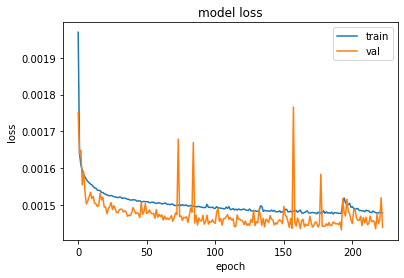

In [ ]:
#History
from google.colab import files
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
ax = plt.gca()
#ax.set_ylim([0, 0.05])
plt.savefig('Fig_DNN_CPPTNet_01.png', dpi = 600)
#files.download("Fig_DNN_CPPTNet_01.png")
plt.show()